In [9]:
import dataloaders.audio_dataset as dataset
import models.inversion_v1 as inversion_model
from abstract_model import AbstractModel

import os
import shutil

import torch
import torchaudio
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchaudio.functional as F

from sklearn.metrics import confusion_matrix

from pytorch_lightning.core.saving import load_hparams_from_yaml

from tensorboard.backend.event_processing import event_accumulator
import numpy as np

from torch.utils.data import DataLoader

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

In [11]:
def _load_run(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []

        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)

        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [12]:
# TEST - SPECIFIC VERSION - MSE loss and amplitude prediction

algo = "inversion_v1"
data_path = "/scratch/prs392/incubator/data/LibriSpeech/"
checkpoint_path = f"/scratch/prs392/incubator/checkpoints/openl3_librispeech/{algo}/"
experiment_name = "train_0.01_with_specific_hparams"

AudioDatasetWithAmp = dataset.AudioDataset
InversionV1 = inversion_model.InversionV1

data_paths = {}
data_paths['train'] = os.path.join(data_path, 'train-clean-360')
data_paths['val'] = os.path.join(data_path, 'dev-clean')
data_paths['test'] = os.path.join(data_path, 'test-clean')

d = os.path.join(checkpoint_path, experiment_name)
versions = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]

versions = sorted(versions)

for version in versions:
    if version == 'version_3':
        hparam_path = os.path.join(checkpoint_path, experiment_name, version, 'hparams.yaml')
        hparams_new = load_hparams_from_yaml(hparam_path)

version = 'version_3'

checkpoint_path = os.path.join(checkpoint_path, experiment_name, version, 'checkpoints')
epoch_file = [o for o in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path,o))][0]

PATH = os.path.join(checkpoint_path, 'last.ckpt') 

model = AbstractModel.load_from_checkpoint(PATH, hparams=hparams_new, 
                                            data_paths = data_paths, 
                                            dataset_model = AudioDatasetWithAmp,
                                            model = InversionV1(), 
                                            criterion = nn.MSELoss())

train_dataset = AudioDatasetWithAmp(root_dir=data_paths['test'], num_audios = hparams_new['test_num_audios'])
# train_loader = DataLoader(train_dataset, batch_size=hparams_new['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

for i in range(len(train_dataset)):
    emb, spec, j = train_dataset[i]
    
    pred = model(emb)
    
#     print("Embeddings shape: " + str(emb.shape))
#     print("Expected Spectrogram shape: " + str(spec.shape))
#     print("Predicted Spectrogram shape: " + str(pred.shape))
    if i == 50:
        break


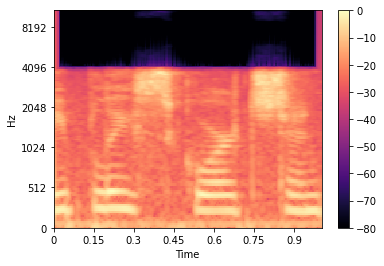

In [13]:
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec[0,:,:].detach().numpy()), ref=np.max), 
                         y_axis='mel', 
                         x_axis='time',
                         sr=asr,
                         hop_length=n_hop)
plt.colorbar()

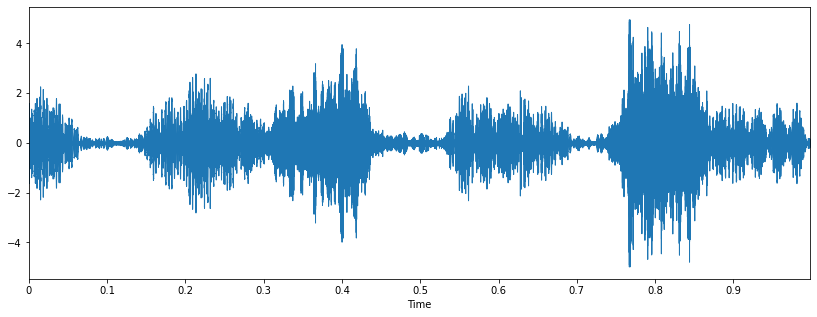

In [14]:

import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = spec[0,:,:].detach()


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp.numpy(), sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=32,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

ipd.Audio(y, rate=48000)


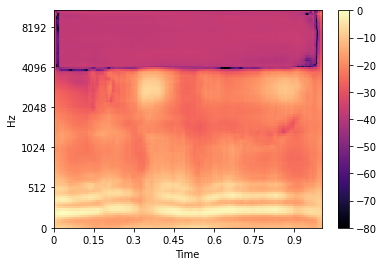

In [15]:
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(pred[0,0,:,:].detach().numpy()), ref=np.max), 
                         y_axis='mel', 
                         x_axis='time',
                         sr=asr,
                         hop_length=n_hop)
plt.colorbar()

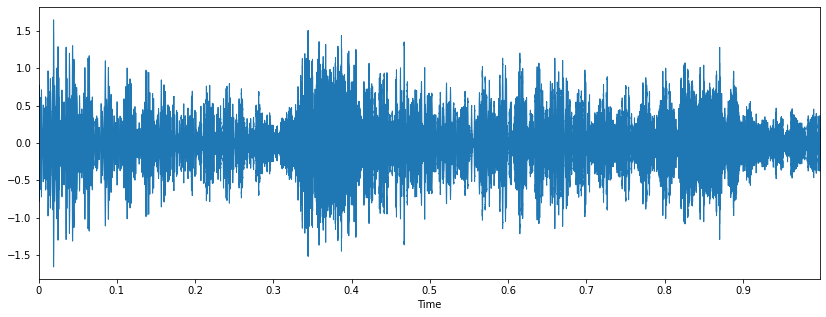

In [16]:

import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = pred[0,0,:,:].detach()


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp.numpy(), sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=32,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

ipd.Audio(y, rate=48000)
